In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/carl')

In [20]:
theta = [[1.0, -0.5, -0.5], 
         [1.0, -0.5, 0.5], 
         [1.0, -0.35714285714285715, -0.071428571428571452], 
         [1.0, -0.35714285714285715, 0.21428571428571419], 
         [1.0, -0.2142857142857143, -0.2142857142857143], 
         [1.0, -0.2142857142857143, 0.071428571428571397], 
         [1.0, -0.2142857142857143, 0.3571428571428571], 
         [1.0, -0.071428571428571452, -0.35714285714285715], 
         [1.0, -0.071428571428571452, -0.071428571428571452], 
         [1.0, -0.071428571428571452, 0.21428571428571419], 
         [1.0, 0.21428571428571419, -0.2142857142857143], 
         [1.0, 0.21428571428571419, 0.071428571428571397], 
         [1.0, 0.3571428571428571, 0.5], 
         [1.0, 0.5, -0.071428571428571452], 
         [1.0, 0.5, 0.21428571428571419],
         [1.0, -0.5, -0.35714285714285715], 
         [1.0, -0.5, -0.071428571428571452], 
         [1.0, -0.5, 0.3571428571428571], 
         [1.0, -0.2142857142857143, -0.071428571428571452], 
         [1.0, -0.2142857142857143, 0.21428571428571419], 
         [1.0, -0.2142857142857143, 0.5], 
         [1.0, -0.071428571428571452, -0.5], 
         [1.0, -0.071428571428571452, -0.2142857142857143], 
         [1.0, -0.071428571428571452, 0.071428571428571397], 
         [1.0, 0.071428571428571397, -0.071428571428571452], 
         [1.0, 0.071428571428571397, 0.3571428571428571], 
         [1.0, 0.21428571428571419, -0.35714285714285715], 
         [1.0, 0.21428571428571419, 0.21428571428571419], 
         [1.0, 0.5, -0.2142857142857143], 
         [1.0, 0.5, 0.5],
         [1.0, 0.0, 0.0]]

theta = np.array(theta)

feature_names = ["minDelR_jZ", "DelPhi_Hjj", "DelEta_Hjj", "DelPhi_jj", "DelR_jj", 
                 "DelY_jj", "Mjj", "DelPt_jj", "DelPt_ZZ", "pT_Hjj", "Mjets", "Zeppetaj3", 
                 "ZeppetaZZ", "njets","Z1_E","Z1_pt","Z1_eta","Z1_phi","Z1_m","Z2_E","Z2_pt",
                 "Z2_eta","Z2_phi","Z2_m",  "higgs_E","higgs_pt","higgs_eta","higgs_phi","higgs_m", 
                 "jet1_E","jet1_eta","jet1_y","jet1_phi","jet1_pt","jet1_m","jet2_E", "jet2_eta","jet2_y", 
                 "jet2_phi","jet2_pt","jet2_m","jet3_E","jet3_eta","jet3_y" ,"jet3_phi","jet3_pt","jet3_m"]
# subset = [33] #jet1_pt
subset = [33, 3]
#subset = [3, 4, 6, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 30, 33, 34, 36, 39, 40]
#subset = list(range(len(feature_names)))

In [21]:
observed = 8
X_observed = np.loadtxt("/afs/cern.ch/work/j/jpavezse/private/data/full_data/data_%d.dat"
                        % observed)[:5000, subset]
X_observed.shape

# ideally, X_observed should be an independent sample not used for training

(5000, 2)

In [22]:
X_num_list = []
for k in range(len(theta)):
    X_num_list.append(np.loadtxt("/afs/cern.ch/work/j/jpavezse/private/data/full_data/data_%d.dat" %
                                 k)[:500000, subset])

In [23]:
theta1 = 0     # arbitrary choice for theta1, should not change results
                # at least in theory...
    
                # for fisher, this needs to be set to observed

X_den = np.loadtxt("/afs/cern.ch/work/j/jpavezse/private/data/full_data/data_%d.dat" % theta1)[:500000, subset]

In [24]:
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedShuffleSplit


def make_ratio(num):
    X_num = X_num_list[num]
    X = np.vstack((X_num, X_den))
    y = np.zeros(len(X), dtype=np.int)
    y[len(X_num):] = 1

    clf = ExtraTreesClassifier(n_estimators=100, min_samples_split=20, random_state=0, n_jobs=-1)
    cv =  StratifiedShuffleSplit(n_iter=3, test_size=0.5, random_state=1)

    ratio = ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=40),
        random_state=0)
    ratio.fit(X, y)
    
    return ratio


def fisher(X_observed, ratio):
    w = ratio.predict(X_observed)
    return np.arccos(np.sum(np.sqrt(w)) / w.size)

In [25]:
llr = []
distances = []
for i in range(len(theta)):
    print(i, theta[i])
    ratio = make_ratio(i)
    llr.append(ratio.nllr(X_observed))
    #distances.append(fisher(X_observed, ratio))
    print(llr[-1])


(0, array([ 1. , -0.5, -0.5]))
21.3042717216
(1, array([ 1. , -0.5,  0.5]))
0.921116080651
(2, array([ 1.        , -0.35714286, -0.07142857]))
0.609001615216
(3, array([ 1.        , -0.35714286,  0.21428571]))
-0.594704175699
(4, array([ 1.        , -0.21428571, -0.21428571]))
-0.932192561143
(5, array([ 1.        , -0.21428571,  0.07142857]))
-0.880973629454
(6, array([ 1.        , -0.21428571,  0.35714286]))
-0.190956583223
(7, array([ 1.        , -0.07142857, -0.35714286]))
0.106189862292
(8, array([ 1.        , -0.07142857, -0.07142857]))
-22.741283442
(9, array([ 1.        , -0.07142857,  0.21428571]))
0.621916312719
(10, array([ 1.        ,  0.21428571, -0.21428571]))
-3.29623016568
(11, array([ 1.        ,  0.21428571,  0.07142857]))
-3.08820692244
(12, array([ 1.        ,  0.35714286,  0.5       ]))
-3.68848602918
(13, array([ 1.        ,  0.5       , -0.07142857]))
0.375000324348
(14, array([ 1.        ,  0.5       ,  0.21428571]))
1.83877898209
(15, array([ 1.        , -0.5  

In [26]:
llr = llr[:29]
llr = np.array(llr)
mle = np.argmin(llr)
llr -= llr[mle]
llr *= 2.

In [27]:
llr_original = llr.copy()

In [28]:
llr *= 19.2 / len(X_observed)

In [29]:
mle

8

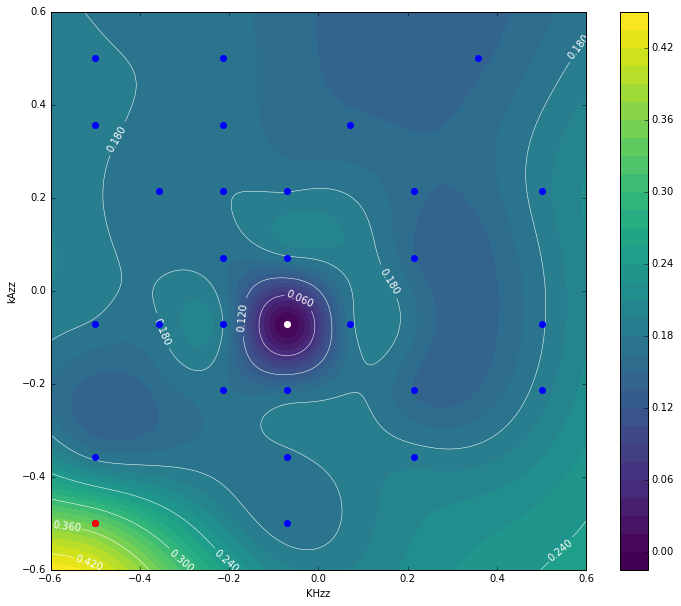

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(theta[:29, 1:], llr)

xi = np.linspace(-0.6, 0.6, 500)
yi = np.linspace(-0.6, 0.6, 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

cs = plt.contour(xi, yi, zi, 8, linewidths=0.5, colors='w')
plt.clabel(cs, inline=1, fontsize=10)
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
plt.colorbar()  
plt.scatter(theta[:29, 1], theta[:29, 2], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([theta[mle, 1]], [theta[mle, 2]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([theta[observed, 1]], [theta[observed, 2]], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([theta[theta1, 1]], [theta[theta1, 2]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel("KHzz")
plt.ylabel("kAzz")
plt.show()

In [45]:
np.savetxt('nodec_likelihood_-0.7_-0.7_sub_den8.txt', zi)

In [64]:
distances[30] = 0.0